# PROJET VISION PAR ORDINATEUR : SEGMENTATION D'OBJECTS D'ANIMAUX AVEC LE DATASET OXFORDS PETS


#Étape 1 : Importation des bibliothèques

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Étape 2 : Téléchargement et préparation du dataset Oxford Pets

In [ ]:
(dataset_train, dataset_test), info = tfds.load(
    "oxford_iiit_pet:4.0.0",
    split=["train", "test"],
    with_info=True,
    as_supervised=False
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.76O4P2_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.76O4P2_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


1. Informations sur le dataset

In [ ]:
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

2. Affichage du contenu du dataset avec 5 images

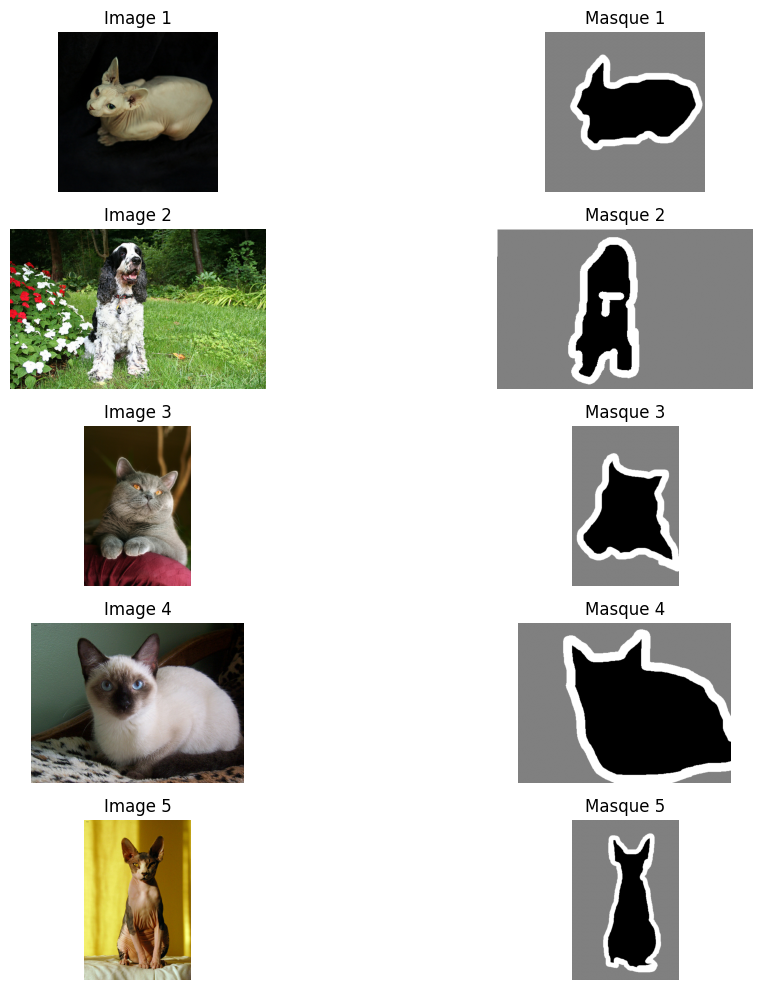

In [ ]:
num_images = 5

plt.figure(figsize=(12, 2 * num_images))

for i, sample in enumerate(dataset_train.take(num_images)):
    image = sample["image"]
    mask = sample["segmentation_mask"]

    # Image
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis("off")

    # Masque
    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(mask[..., 0], cmap="gray")
    plt.title(f"Masque {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Nous avons pris ici l'exemple de 5 images originales pour voir exactement l'emplacement du masque

# Étape 3 : Prétaitement du dataset

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 16


1. Redimensionnement et normalisation des données

In [ ]:
import tensorflow as tf

def preprocess(sample):
    image = sample["image"]
    mask = sample["segmentation_mask"]

    # Redimensionnement
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")

    # Normalisation image
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.cast(mask[..., 0], tf.int32) - 1

    return image, mask


In [ ]:
train_ds = dataset_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = dataset_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


2. Visualisation après prétaitement des images

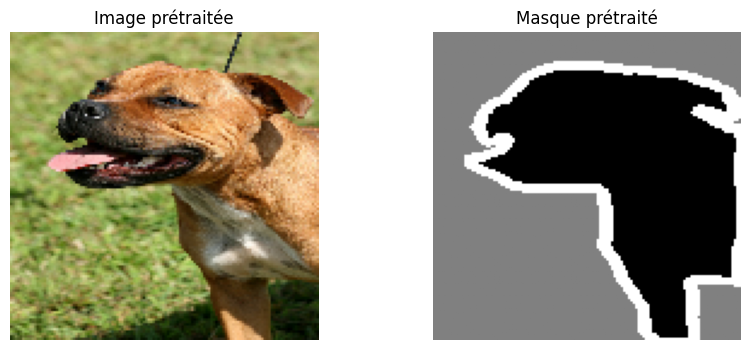

In [ ]:

for images, masks in train_ds.take(1):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(images[0])
    plt.title("Image prétraitée")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(masks[0], cmap="gray")
    plt.title("Masque prétraité")
    plt.axis("off")

    plt.show()


3. COMPARAISON D'IMAGES PRETRAITEES ET TRAITEES

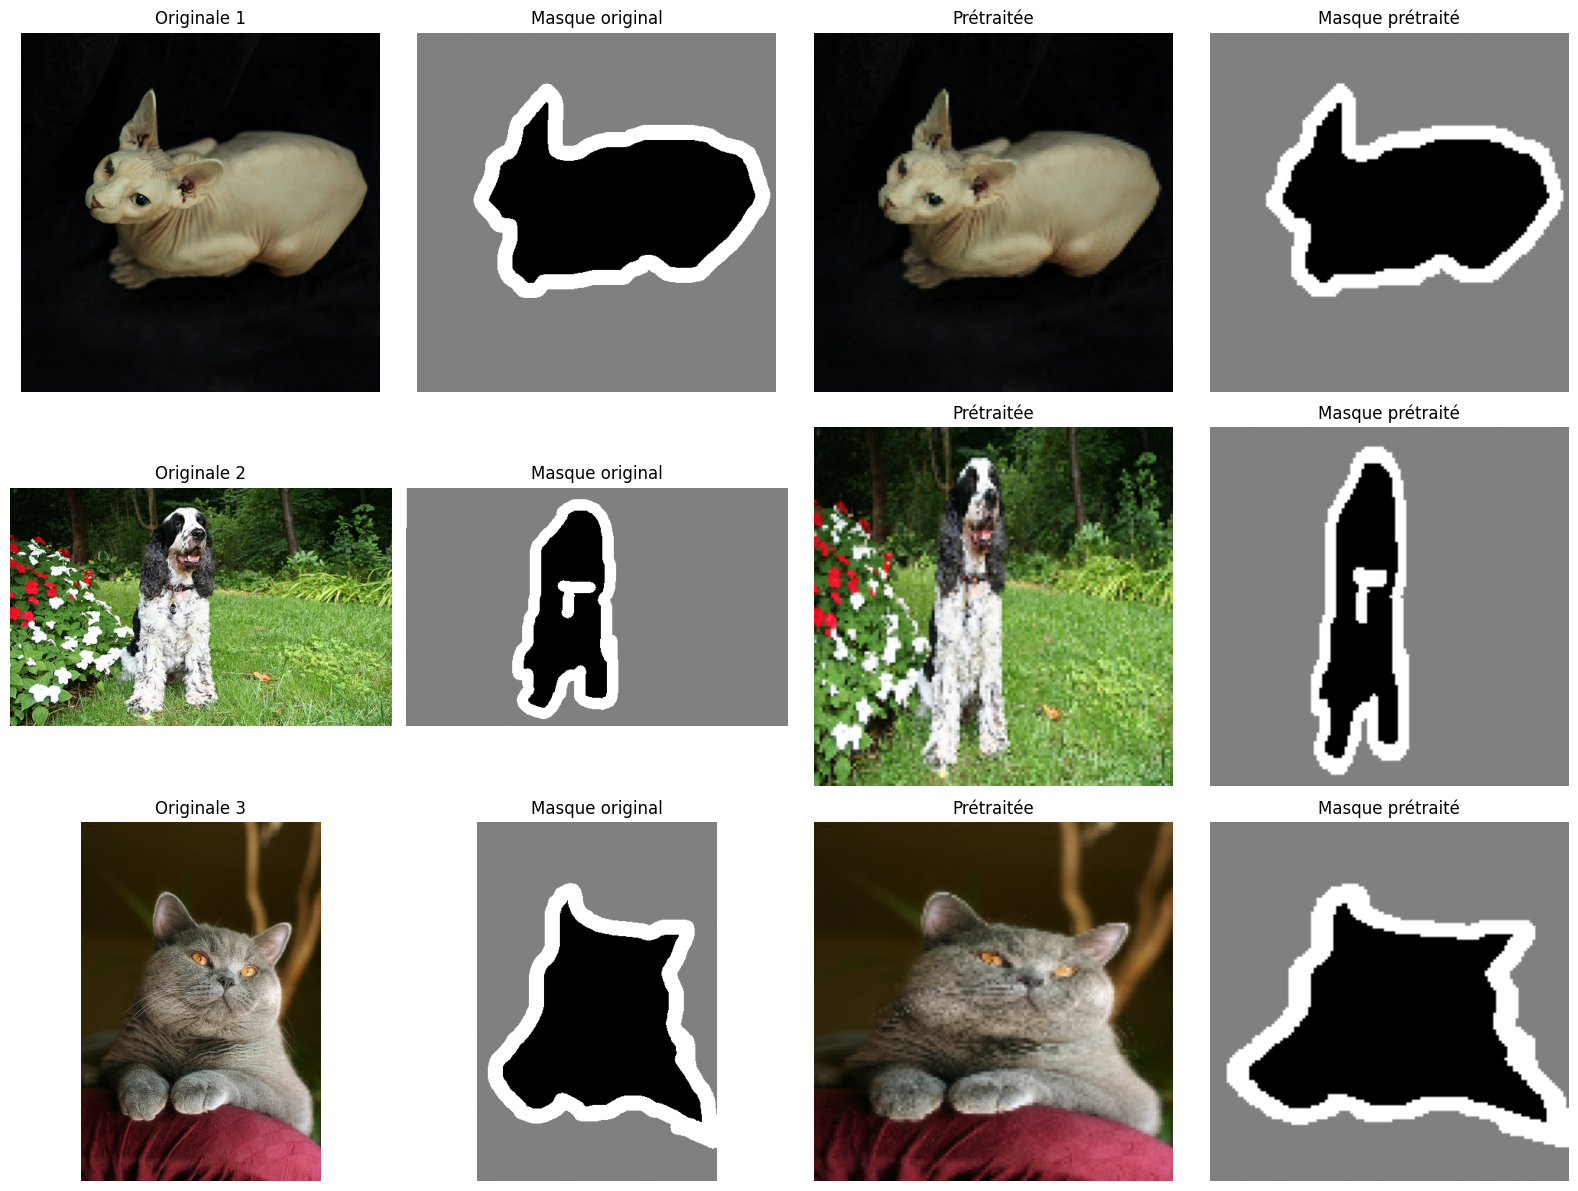

In [ ]:
num_images = 3

plt.figure(figsize=(16, 4 * num_images))

for i, sample in enumerate(dataset_train.take(num_images)):
    # Original
    orig_image = sample["image"]
    orig_mask = sample["segmentation_mask"]

    # Prétraité
    proc_image, proc_mask = preprocess(sample)

    # Image originale
    plt.subplot(num_images, 4, 4*i + 1)
    plt.imshow(orig_image)
    plt.title(f"Originale {i+1}")
    plt.axis("off")

    # Masque original
    plt.subplot(num_images, 4, 4*i + 2)
    plt.imshow(orig_mask[..., 0], cmap="gray")
    plt.title("Masque original")
    plt.axis("off")

    # Image prétraitée
    plt.subplot(num_images, 4, 4*i + 3)
    plt.imshow(proc_image)
    plt.title("Prétraitée")
    plt.axis("off")

    # Masque prétraité
    plt.subplot(num_images, 4, 4*i + 4)
    plt.imshow(proc_mask, cmap="gray")
    plt.title("Masque prétraité")
    plt.axis("off")

plt.tight_layout()
plt.show()


Vous remarquerez ici qu'il y'a une nette amélioration concernant la taille des images et des masques

# Étape 4 : CREATION DU MODELE UNET-RESNET50

1. Création du modèle Resnet50

In [ ]:
def unet_resnet50_fixed(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=3):
    inputs = tf.keras.Input(input_size)
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # Skip connections
    skip_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]
    skips = [base_model.get_layer(name).output for name in skip_names]

    x = base_model.output

    for i in reversed(range(len(skips))):
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(x)
        x = tf.keras.layers.Concatenate()([x, skips[i]])
        x = tf.keras.layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)

    # UpSampling final pour correspondre exactement à 128x128
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(x)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)


In [ ]:
model_resnet_fixed = unet_resnet50_fixed()
print(model_resnet_fixed.output.shape)

(None, 128, 128, 3)


2. Compilation du modèle

In [ ]:
model_resnet_fixed = unet_resnet50_fixed()
model_resnet_fixed.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


3. Entraînement du modèle

In [ ]:
EPOCHS = 10

history_resnet = model_resnet_fixed.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 143s 324ms/step - accuracy: 0.6966 - loss: 1.0178 - val_accuracy: 0.5772 - val_loss: 2.1877
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 72s 301ms/step - accuracy: 0.8616 - loss: 0.3612 - val_accuracy: 0.5883 - val_loss: 1.5002
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 68s 284ms/step - accuracy: 0.8774 - loss: 0.3231 - val_accuracy: 0.7653 - val_loss: 0.6722
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 69s 283ms/step - accuracy: 0.8906 - loss: 0.2817 - val_accuracy: 0.8398 - val_loss: 0.4100
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 67s 283ms/step - accuracy: 0.8958 - loss: 0.2702 - val_accuracy: 0.8725 - val_loss: 0.3382
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 69s 286ms/step - accuracy: 0.9048 - loss: 0.2445 - val_accuracy: 0.7733 - val_loss: 0.9110
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 70s 291ms/step - accuracy: 0.9052 - loss: 0.2434 - val_accuracy: 0.8817 - val_loss: 0.3135
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 81s 291ms/step - accuracy: 0.9067 - loss: 

In [ ]:
loss0, accuracy0 = model_resnet_fixed.evaluate(test_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8787 - loss: 0.3414
initial loss: 0.34
initial accuracy: 0.88


4. Visualisation des résultats d’entraînement

Traçage des graphiques de la fonction perte (Loss) et de la précision (Accuracy) sur les jeux d’entraînement et de validation

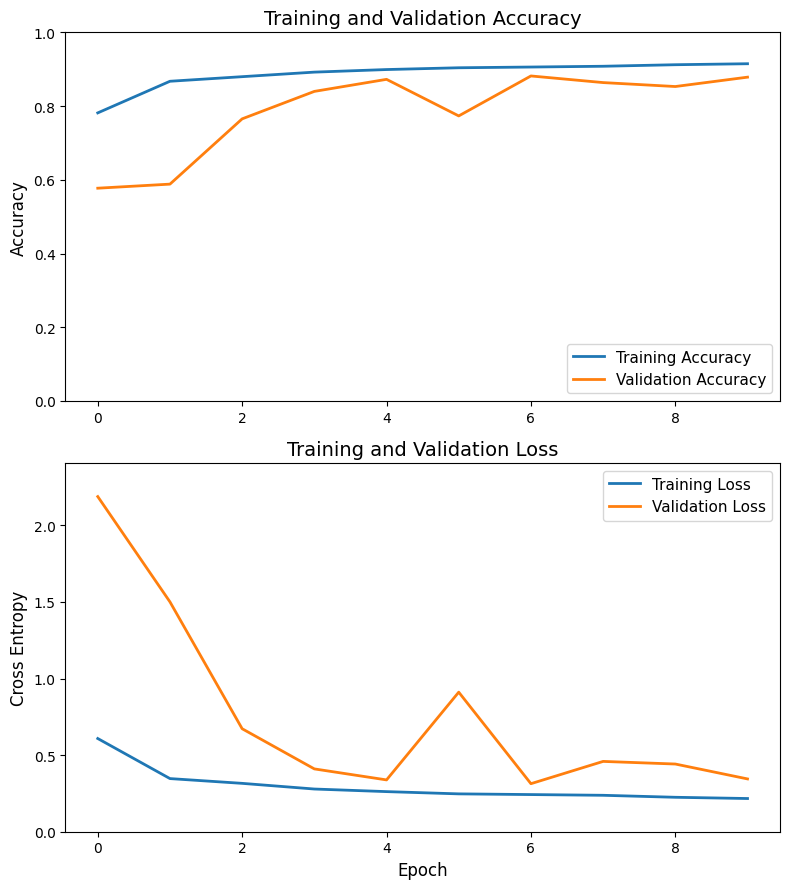

In [ ]:
# Récupérer les valeurs depuis l'historique du modèle ResNet
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(8, 9))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy', fontsize=14)
plt.grid(False)

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right', fontsize=11)
plt.ylabel('Cross Entropy', fontsize=12)
plt.ylim([0, max(max(loss), max(val_loss)) * 1.1])
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.grid(False)

plt.tight_layout()
plt.show()


Ces graphiques montrent l'évolution de l'accuracy et de la loss du modèle pendant l'entraînement et la validation.

5. Visualisation entre masque réel et prédit

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


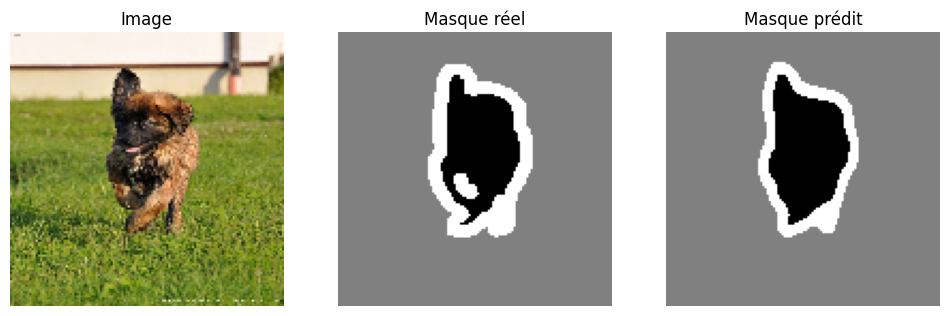

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


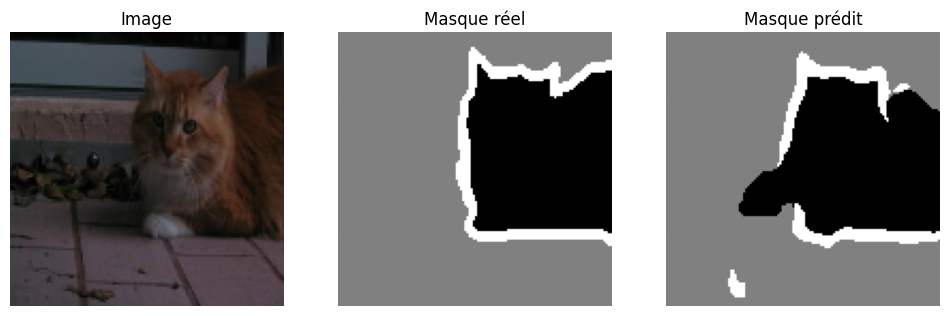

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


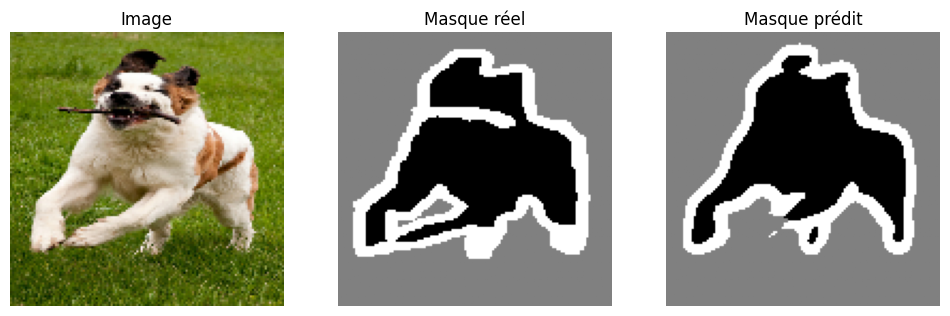

In [ ]:
for batch in test_ds.take(1):
    images, masks = batch

    # On limite à 3 images
    for i in range(3):
        image = images[i]
        mask = masks[i]

        # Prédiction
        pred = model_resnet_fixed.predict(tf.expand_dims(image, 0))
        pred_mask = tf.argmax(pred[0], axis=-1)  # convertion en masque de classes

        # Visualisation
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()


# FINETUNING AVEC RESNET50

Dans cette étape, nous appliquons le fine-tuning sur le modèle Resnet50. Le fine-tuning consiste à ré-entraîner certaines couches du modèle pré-entraîné sur notre jeu de données spécifique, afin d’adapter les représentations apprises aux particularités de notre tâche de segmentation.

In [ ]:
# 1️⃣ Toutes les couches avant un certain index
fine_tune_at = 100

for i, layer in enumerate(model_resnet_fixed.layers):
    if i < fine_tune_at:
        layer.trainable = False
    else:
        layer.trainable = True

# 2️⃣ Recompilation du modèle pour prendre en compte les changements
base_learning_rate = 1e-4
model_resnet_fixed.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3️⃣ Fine-tuning
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model_resnet_fixed.fit(
    train_ds,
    validation_data=test_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS
)


Epoch 11/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 108s 296ms/step - accuracy: 0.9047 - loss: 0.2426 - val_accuracy: 0.8884 - val_loss: 0.3035
Epoch 12/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 259ms/step - accuracy: 0.9100 - loss: 0.2283 - val_accuracy: 0.8899 - val_loss: 0.2986
Epoch 13/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 64s 269ms/step - accuracy: 0.9136 - loss: 0.2176 - val_accuracy: 0.8909 - val_loss: 0.2951
Epoch 14/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 66s 270ms/step - accuracy: 0.9137 - loss: 0.2179 - val_accuracy: 0.8915 - val_loss: 0.2936
Epoch 15/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 61s 254ms/step - accuracy: 0.9154 - loss: 0.2130 - val_accuracy: 0.8926 - val_loss: 0.2917
Epoch 16/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 65s 272ms/step - accuracy: 0.9156 - loss: 0.2133 - val_accuracy: 0.8931 - val_loss: 0.2902
Epoch 17/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 79s 257ms/step - accuracy: 0.9162 - loss: 0.2109 - val_accuracy: 0.8938 - val_loss: 0.2897
Epoch 18/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 257ms/step - accuracy: 0.9174 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

1. Visualisation de la loss et de l'accuracy après le FineTuning

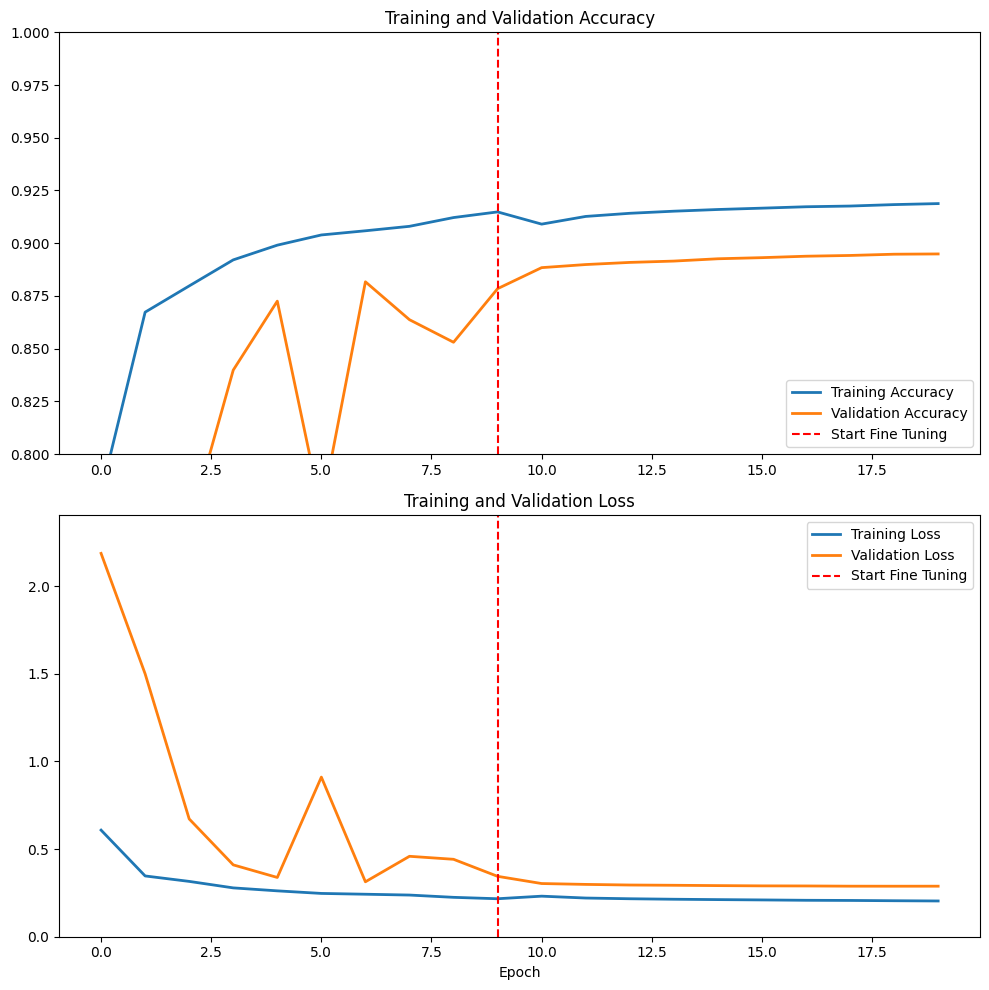

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning', linestyle='--', color='red')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.ylim([0, max(max(loss), max(val_loss))*1.1])
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning', linestyle='--', color='red')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

Ces graphiques montrent l'évolution de l'accuracy et de la loss du modèle pendant l'entraînement et la validation.

2. Évaluation du modèle sur le dataset de test

In [ ]:

loss, accuracy = model_resnet_fixed.evaluate(test_ds)
print("Test Loss     :", loss)
print("Test Accuracy :", accuracy)


230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8962 - loss: 0.2833
Test Loss     : 0.28837889432907104
Test Accuracy : 0.8948873281478882


3. Visualisation entre masque réel et prédit

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


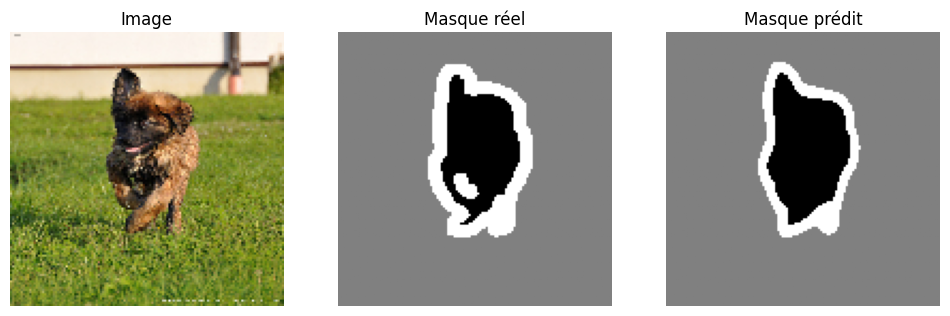

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


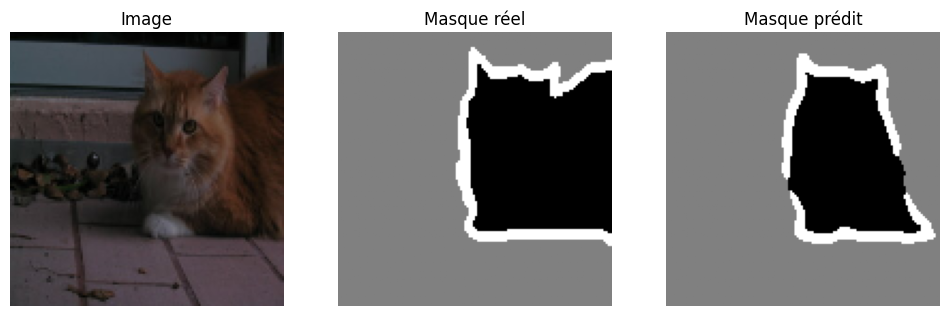

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


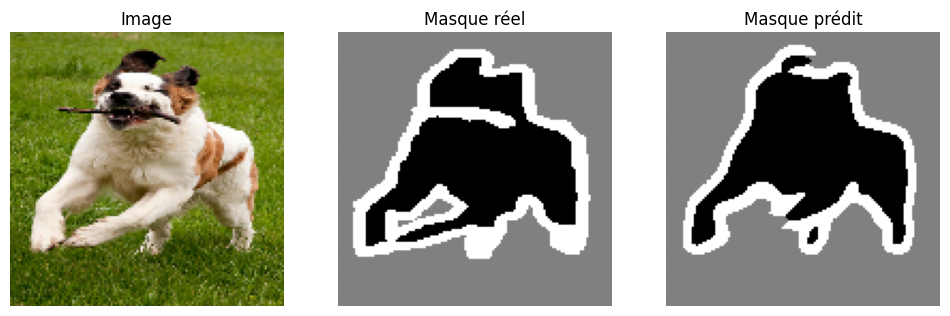

In [ ]:
for batch in test_ds.take(1):
    images, masks = batch

    # Limiter à 3 images
    for i in range(min(3, images.shape[0])):
        image = images[i]
        mask = masks[i]

        # Prédiction
        pred = model_resnet_fixed.predict(tf.expand_dims(image, 0))
        pred_mask = tf.argmax(pred[0], axis=-1)  # convertir en masque de classes

        # Visualisation
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()


On remarque une amélioration après le Finetuning.

Le masque de segmentation est beaucoup plus visible et nette qu'avant.

# Étape 5 : CREATION DU MODELE UNET-MOBILENETV5

In [ ]:
IMG_SIZE = 128
NUM_CLASSES = 3
BATCH_SIZE = 16

1. Création et compilation du modèle

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

IMG_SIZE = 128
NUM_CLASSES = 3

def unet_mobilenet(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(input_size)

    # Base MobileNetV2
    base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')

    # Skip connections
    skip_names = ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu"]
    skips = [base_model.get_layer(name).output for name in skip_names]

    x = base_model.output  # bottleneck

    # Decoder
    for i in reversed(range(len(skips))):
        x = layers.UpSampling2D((2,2), interpolation='bilinear')(x)
        x = layers.Concatenate()([x, skips[i]])
        x = layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)

    # UpSampling final pour correspondre à 128x128
    x = layers.UpSampling2D((2,2), interpolation='bilinear')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Création du modèle
model_mobilenet = unet_mobilenet()
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()


/tmp/ipython-input-4076263064.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,462,339 (17.02 MB)

 Trainable params: 4,428,227 (16.89 MB)

 Non-trainable params: 34,112 (133.25 KB)

2. Evaluation

In [ ]:
EPOCHS = 10

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 153s 358ms/step - accuracy: 0.7585 - loss: 0.5840 - val_accuracy: 0.7046 - val_loss: 0.9860
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - accuracy: 0.8901 - loss: 0.2823 - val_accuracy: 0.7875 - val_loss: 0.6897
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 241ms/step - accuracy: 0.9082 - loss: 0.2332 - val_accuracy: 0.8641 - val_loss: 0.3892
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 57s 239ms/step - accuracy: 0.9137 - loss: 0.2175 - val_accuracy: 0.8323 - val_loss: 0.5075
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 57s 238ms/step - accuracy: 0.9195 - loss: 0.2003 - val_accuracy: 0.8533 - val_loss: 0.4546
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 239ms/step - accuracy: 0.9224 - loss: 0.1926 - val_accuracy: 0.8747 - val_loss: 0.3878
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 59s 240ms/step - accuracy: 0.9274 - loss: 0.1785 - val_accuracy: 0.8983 - val_loss: 0.3137
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 58s 239ms/step - accuracy: 0.9305 - loss: 

In [ ]:
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

3. Visualisation de loss et de l'accuracy du modèle

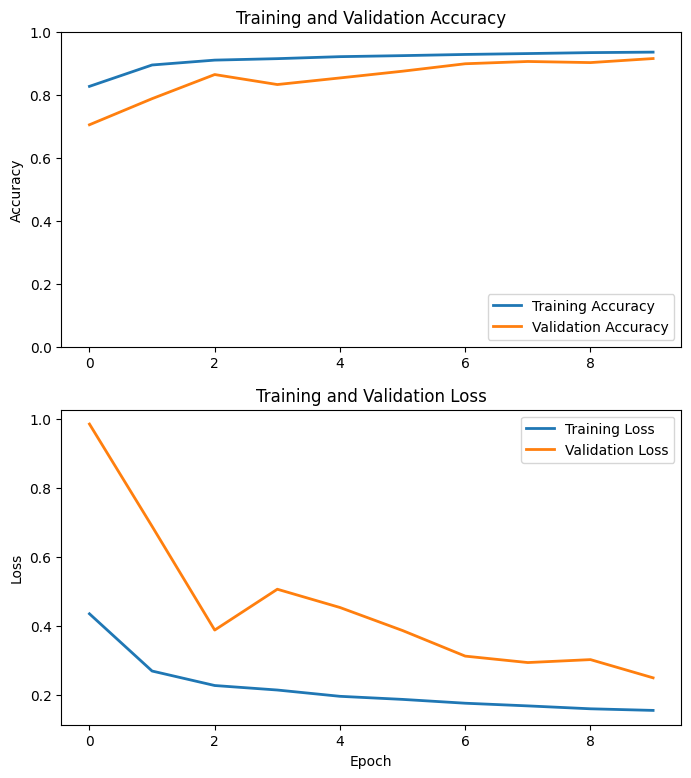

In [ ]:
plt.figure(figsize=(8, 9))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

Ces graphiques montrent l'évolution de l'accuracy et de la loss du modèle pendant l'entraînement et la validation.

4. Evaluation du modèle

In [ ]:
loss, accuracy = model_resnet_fixed.evaluate(test_ds)
print("Test Loss     :", loss)
print("Test Accuracy :", accuracy)


230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8962 - loss: 0.2833
Test Loss     : 0.28837889432907104
Test Accuracy : 0.8948873281478882


Avant finetuning du modèle MobileNet on enregistre un Loss de 28% et un Accuracy de 89%.

5. Visualisation entre image réel et prédit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


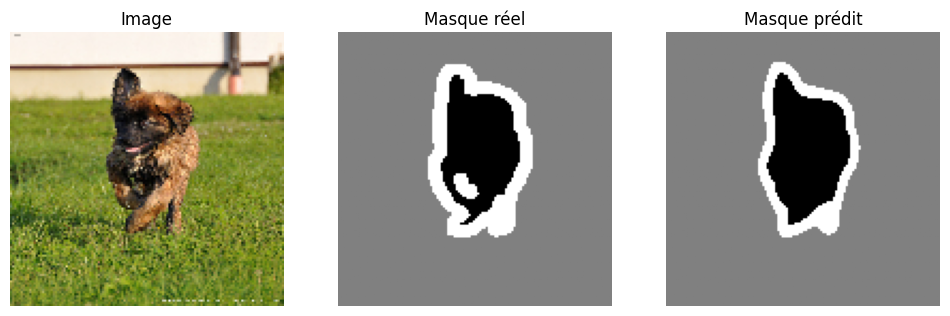

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


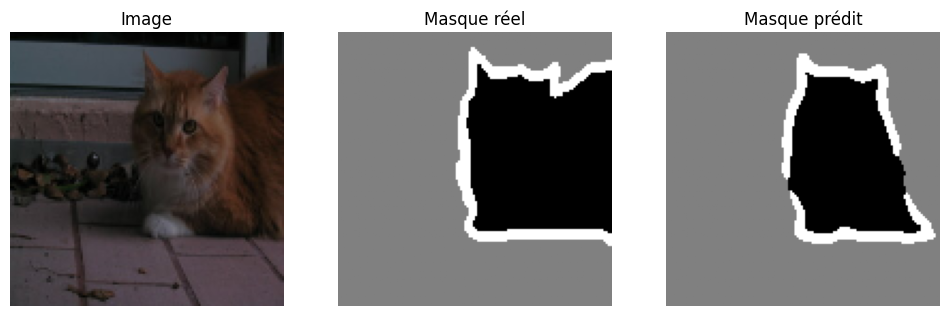

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


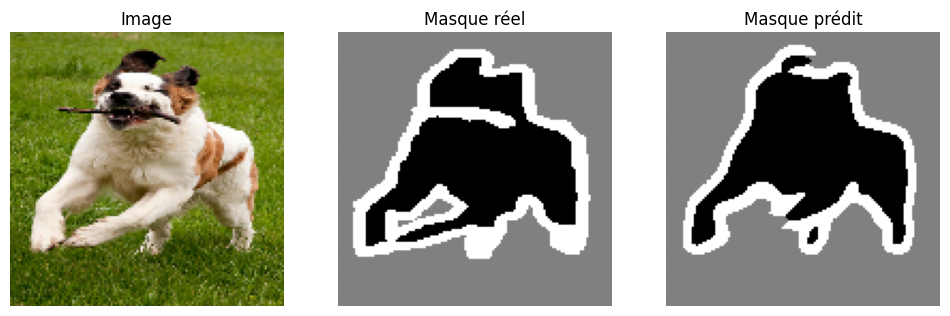

In [ ]:
# Prendre un batch du test
for batch in test_ds.take(1):  # un batch
    images, masks = batch  # images: (BATCH_SIZE, 128,128,3), masks: (BATCH_SIZE,128,128)

    # Limiter à 3 images
    for i in range(min(3, images.shape[0])):
        image = images[i]
        mask = masks[i]

        # Prédiction
        pred = model_resnet_fixed.predict(tf.expand_dims(image, 0))  # shape: (1,128,128,3)
        pred_mask = tf.argmax(pred[0], axis=-1)  # convertir en masque de classes

        # Visualisation
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()


# FINETUNING AVEC MOBILENET

Dans cette étape, nous appliquons le fine-tuning sur le modèle MobileNetV2. Le fine-tuning consiste à ré-entraîner certaines couches du modèle pré-entraîné sur notre jeu de données spécifique, afin d’adapter les représentations apprises aux particularités de notre tâche de segmentation.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Paramètres
IMG_SIZE = 128
NUM_CLASSES = 3  # à adapter selon ton dataset
BATCH_SIZE = 16  # exemple
EPOCHS = 10

# 🔹 Définition du U-Net avec MobileNetV2
def unet_mobilenet(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(input_size)

    # Backbone MobileNetV2
    backbone = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)

    # Skip connections
    skip_names = [
        "block_1_expand_relu",
        "block_3_expand_relu",
        "block_6_expand_relu",
        "block_13_expand_relu"
    ]
    skips = [backbone.get_layer(name).output for name in skip_names]

    x = backbone.output

    # Decoder
    for i in reversed(range(len(skips))):
        x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        x = layers.Concatenate()([x, skips[i]])
        x = layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)

    # Upsampling final pour correspondre à 128x128
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    return models.Model(inputs, outputs)

# 🔹 Créer et compiler le modèle
model_mobilenet = unet_mobilenet()
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()


/tmp/ipython-input-3764736315.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,462,339 (17.02 MB)

 Trainable params: 4,428,227 (16.89 MB)

 Non-trainable params: 34,112 (133.25 KB)

#### Entrainement du modèle

In [ ]:
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS
)

Epoch 11/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 106s 240ms/step - accuracy: 0.7352 - loss: 0.6268 - val_accuracy: 0.7053 - val_loss: 0.9380
Epoch 12/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 258ms/step - accuracy: 0.8891 - loss: 0.2852 - val_accuracy: 0.8353 - val_loss: 0.5181
Epoch 13/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 63s 259ms/step - accuracy: 0.9052 - loss: 0.2418 - val_accuracy: 0.7750 - val_loss: 0.7818
Epoch 14/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 57s 234ms/step - accuracy: 0.9142 - loss: 0.2144 - val_accuracy: 0.8564 - val_loss: 0.4090
Epoch 15/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 235ms/step - accuracy: 0.9177 - loss: 0.2058 - val_accuracy: 0.8631 - val_loss: 0.4264
Epoch 16/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 234ms/step - accuracy: 0.9226 - loss: 0.1913 - val_accuracy: 0.8885 - val_loss: 0.3491
Epoch 17/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 56s 234ms/step - accuracy: 0.9283 - loss: 0.1763 - val_accuracy: 0.9072 - val_loss: 0.2668
Epoch 18/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 62s 258ms/step - accuracy: 0.9284 

#### Evaluation et visualation d'images sur le modèle

230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9075 - loss: 0.2845
Test Loss: 0.2935025691986084
Test Accuracy: 0.906105101108551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


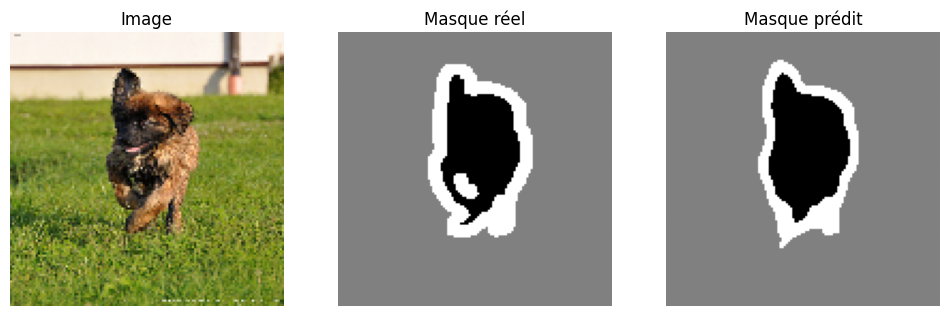

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


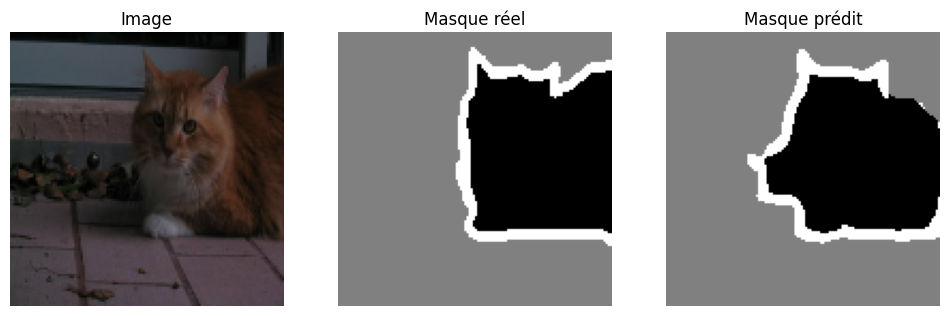

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


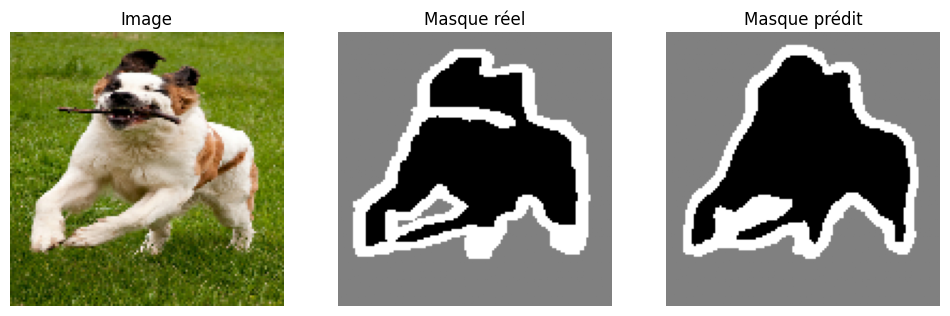

In [ ]:
loss, accuracy = model_mobilenet.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Visualisation sur 3 images
for batch in test_ds.take(1):
    images, masks = batch
    for i in range(3):
        image = images[i]
        mask = masks[i]
        pred = model_mobilenet.predict(tf.expand_dims(image, 0))
        pred_mask = tf.argmax(pred[0], axis=-1)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")
        plt.show()


Après finetuning du modèle MobileNet on enregistre un Loss de 29% et un Accuracy de 90%.
On déduit donc qu'il y a une petite amélioration.

### COMPARAISON VISUELLE APRES FINETUNING DE RESNET VS MOBILENET

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


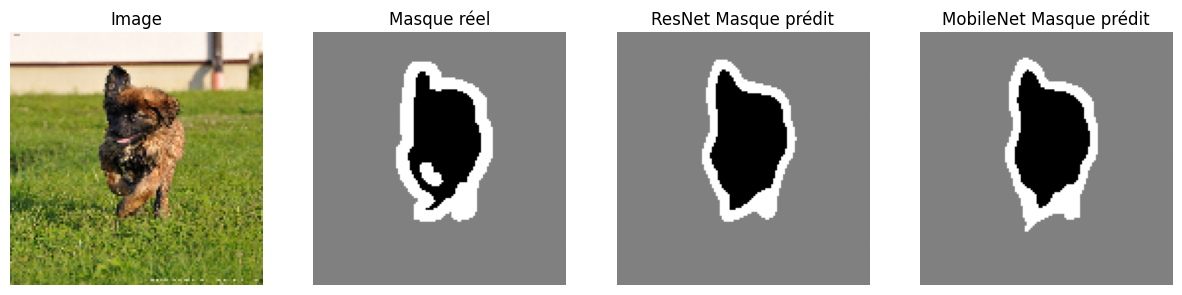

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


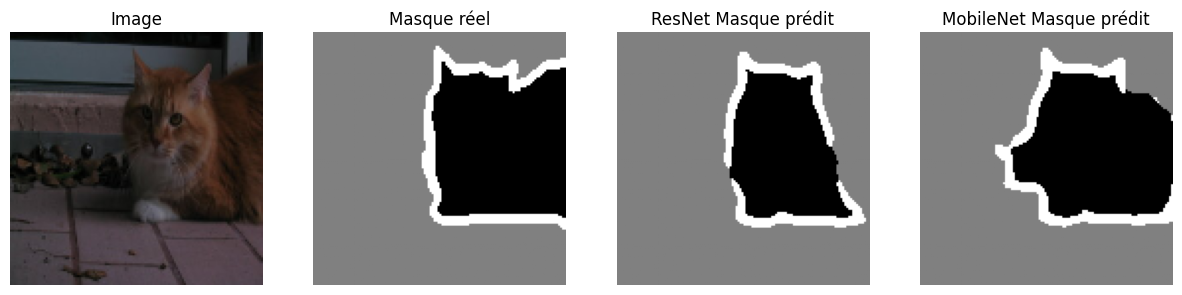

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


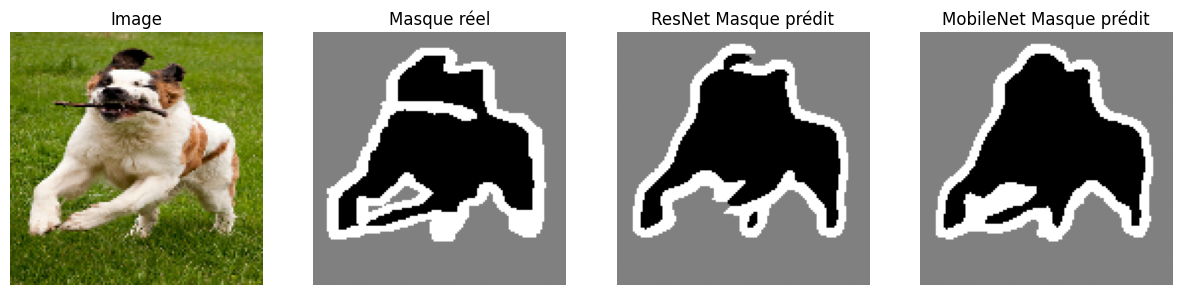

In [ ]:
for batch in test_ds.take(1):
    images, masks = batch
    for i in range(3):  # 3 images
        image = images[i]
        mask = masks[i]

        # Prédictions
        pred_resnet = model_resnet_fixed.predict(tf.expand_dims(image, 0))
        pred_resnet_mask = tf.argmax(pred_resnet[0], axis=-1)

        pred_mobilenet = model_mobilenet.predict(tf.expand_dims(image, 0))
        pred_mobilenet_mask = tf.argmax(pred_mobilenet[0], axis=-1)

        # Affichage
        plt.figure(figsize=(15,5))

        plt.subplot(1,4,1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,4,2)
        plt.imshow(mask, cmap='gray')
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1,4,3)
        plt.imshow(pred_resnet_mask, cmap='gray')
        plt.title("ResNet Masque prédit")
        plt.axis("off")

        plt.subplot(1,4,4)
        plt.imshow(pred_mobilenet_mask, cmap='gray')
        plt.title("MobileNet Masque prédit")
        plt.axis("off")

        plt.show()


On remarque par exemple que ResNet50 fournit des prédictions assez précises dès l’entraînement initial, tandis que MobileNetV2, plus léger, parvient à obtenir des résultats similaires après un fine-tuning adapté. Cette comparaison visuelle complète les métriques quantitatives d’accuracy et de loss déjà calculées.

**CONCLUSION**

Le projet montre que le MobileNetV2 avec des backbones pré-entraînés est efficace pour la segmentation sémantique.

*   ResNet50 est robuste et profond, mais plus lent à entraîner.
*   MobileNetV2 est léger et rapide, et atteint des performances comparables, voire légèrement supérieures après fine-tuning.




Ainsi, pour un bon compromis entre vitesse et précision, MobileNetV2 est recommandé pour ce dataset.